In [2]:
import pandas as pd
import numpy as np
import re
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_parts = pd.read_csv("../Datas/df_parts_an_c_paul.csv")

In [4]:
df_parts.loc[df_parts["part_num"] == "56093"].head()

,inventory_id,part_num,color_id,quantity,is_spare,name_part,part_cat_id,part_material,name_color,rgb,name_cat,version,set_num,name_sets,year,theme_id,name_univ
144141,5750,56093,1080,1,f,"Animal, Lemur (Momo)",28,Plastic,Light Tan,F3C988,Plants and Animals,1,3828-1,Air Temple,2006.0,317.0,Avatar: The Last Airbender


# Nombre de Pièces unique :

In [5]:
print("Il y a ",df_parts["name_part"].nunique(),"pièces différentes")

Il y a  50177 pièces différentes


In [6]:
print("Il y a ",df_parts["name_cat"].nunique(),"varièté de pièces différentes")

Il y a  66 varièté de pièces différentes


In [7]:
df_parts["name_cat"].value_counts(normalize = True).round(2)*100

Plates                 14.0
Bricks                  8.0
Plates Special          8.0
Bricks Sloped           6.0
Tiles                   5.0
                       ... 
Other                   0.0
Magnets and Holders     0.0
HO Scale                0.0
Znap                    0.0
Mechanical              0.0
Name: name_cat, Length: 66, dtype: float64

# Matériel utilisée

In [8]:
df_mat = df_parts["part_material"].value_counts(normalize = True, ascending=True).round(4)*100
df_mat = pd.DataFrame(df_mat).reset_index()
df_mat["colors"] = ['#D20900', '#D20900', '#D20900', '#D20900', '#D20900', '#D20900', '#FCF40C']
df_mat

,index,part_material,colors
0,Foam,0.01,#D20900
1,Metal,0.01,#D20900
2,Flexible Plastic,0.02,#D20900
3,Cloth,0.17,#D20900
4,Cardboard/Paper,0.20,#D20900
5,Rubber,0.72,#D20900
6,Plastic,98.87,#FCF40C


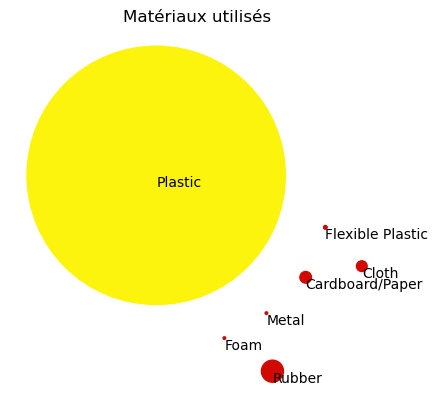

In [9]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='left', verticalalignment='top')


bubble_chart = BubbleChart(area=df_mat["part_material"],
                           bubble_spacing=2.0)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, df_mat["index"], df_mat["colors"])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Matériaux utilisés')
fig.savefig('Matériaux utilisés.png')

plt.show()

In [10]:
display(df_parts.groupby("part_material")["year"].value_counts(ascending=True).unstack().fillna(0))

year,1949.0,1950.0,1953.0,1954.0,1955.0,1956.0,1957.0,1958.0,1959.0,1960.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
part_material,,,,,,,,,,,,,,,,,,,,,
Cardboard/Paper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,87.0,26.0,263.0,474.0,121.0,13.0,165.0,12.0,7.0,1.0
Cloth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.0,43.0,28.0,36.0,31.0,26.0,44.0,51.0,15.0,28.0
Flexible Plastic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,10.0,15.0,22.0,16.0,24.0,14.0,26.0,23.0
Foam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Metal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,2.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0
Plastic,171.0,22.0,26.0,109.0,243.0,152.0,285.0,653.0,18.0,70.0,...,42993.0,50016.0,51166.0,56832.0,58577.0,64055.0,72254.0,79004.0,75822.0,69449.0
Rubber,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,336.0,323.0,276.0,316.0,284.0,312.0,335.0,352.0,319.0,239.0


# Nombre de pièce disponible par an / interoger prendre en compte les valeurs extrèmes

In [39]:
df_parts_by_years = df_parts.groupby("year")["part_num"].count()
df_parts_by_years

year
1949.0      171
1950.0       22
1953.0       26
1954.0      109
1955.0      243
          ...  
2019.0    64422
2020.0    72822
2021.0    79433
2022.0    76189
2023.0    69741
Name: part_num, Length: 73, dtype: int64

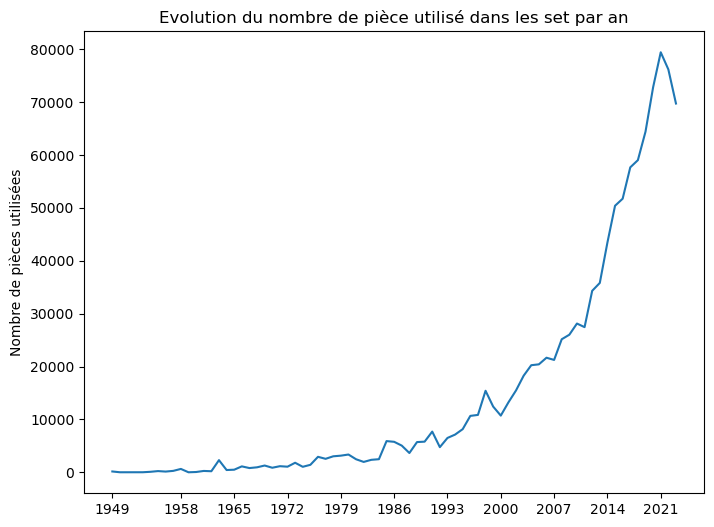

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plt.plot(df_parts_by_years, label='Nb of parts')

plt.xticks(df_parts_by_years.index[::7].astype(int), df_parts_by_years.index[::7].astype(int))

ax.set_ylabel('Nombre de pièces utilisées')
ax.set_title('Evolution du nombre de pièce utilisé dans les set par an')
fig.savefig('Nombre de pièces utilisées.png')
plt.show()

# Proportion des pièce de rechange dans les boites attention, par pièce et par boite

In [13]:
df_spare = df_parts.groupby("year")["is_spare"].value_counts().unstack().fillna(0)
df_spare["% de pièce de rechange"] = ((df_spare["t"]/(df_spare["f"]+df_spare["t"]))*100).round(2)
df_spare["% de pièce de principale"] = ((df_spare["f"]/(df_spare["f"]+df_spare["t"]))*100).round(2)
df_spare.index = df_spare.index.astype(int)

In [40]:
df_spare.describe()

is_spare,f,t,% de pièce de rechange,% de pièce de principale
count,73.000000,73.000000,73.000000,73.000000
mean,14048.301370,1026.767123,2.740959,97.259041
std,19461.197406,1931.001809,3.092795,3.092795
min,19.000000,0.000000,0.000000,90.110000
25%,1075.000000,1.000000,0.050000,95.870000
50%,5015.000000,62.000000,1.570000,98.430000
75%,19669.000000,837.000000,4.130000,99.950000
max,71581.000000,7852.000000,9.890000,100.000000


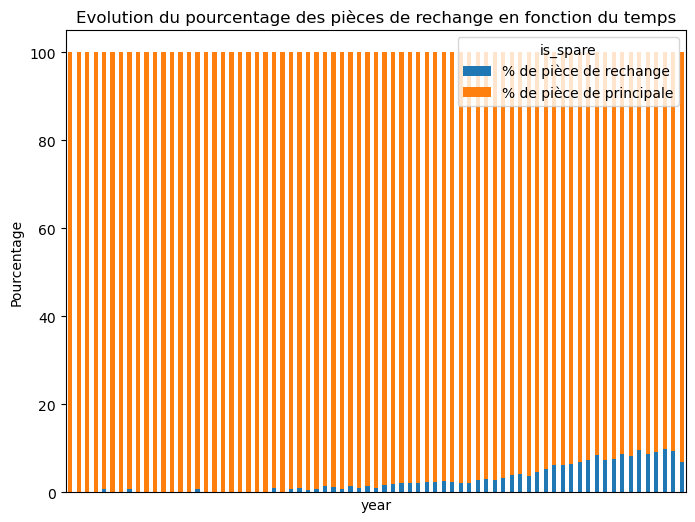

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
df_spare.iloc[:,[2,3]].plot(kind='bar', stacked = True, ax = ax)
ax.set_xticks([])
ax.set_ylabel('Pourcentage')
ax.set_title('Evolution du pourcentage des pièces de rechange en fonction du temps')
fig.savefig('Pourcentage.png')
plt.show()

# Les pièce les plus utiliser de tous les temps

In [15]:
df_most_used_alltime = df_parts.groupby("name_part")["quantity"].sum()
df_most_used_alltime.sort_values(ascending=False, inplace=True)
df_most_used_alltime = df_most_used_alltime.to_frame()
df_most_used_alltime

,quantity
name_part,
Plate 1 x 2,125719
Plate Round 1 x 1 with Solid Stud,117462
Brick 1 x 2,99181
Plate 1 x 1,90551
Brick 1 x 1,74886
...,...
"Minifig Head Leonard Hofstadter, Dual Sided, Glasses, Brown Eyebrows, Open Mouth / Confused [Hollow Stud]",1
"Minifig Head Leia, Female, Dark Tan Eyebrows, Peach Lips, Smile Print",1
"Minifig Head Leia, Dual Sided, Female Brown Eyebrows, Red Lips, Smile / Breathing Mask Print [Hollow Stud]",1


In [16]:
display(df_most_used_alltime.max()/df_most_used_alltime["quantity"].sum()*100)

quantity    3.205613
dtype: float64

In [17]:
df_most_used_alltime["quantity"].sum()

3921840

In [18]:
df_most_used_alltime_df = df_most_used_alltime.reset_index()
df_most_used_alltime_df.to_csv('../Datas/df_most_used_alltime_paul.csv')

# Analyses utilisation uniuqe de pièces

In [19]:
unique_parts = df_most_used_alltime[df_most_used_alltime == 1]
print (unique_parts.count())

quantity    28038
dtype: int64


In [20]:
print (unique_parts.count() / df_most_used_alltime.count())

quantity    0.558782
dtype: float64


# Univers avec les plus de pièce unique

In [21]:
unique_parts_i = unique_parts.index
unique_parts_i = np.array(unique_parts_i)

In [22]:
unique_df = df_parts.loc[df_parts["name_part"].isin(unique_parts_i)]
unique_series = unique_df["name_univ"].value_counts().head(20)

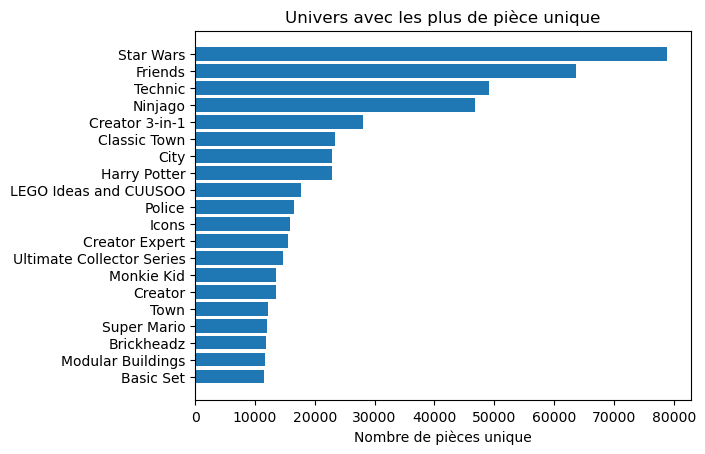

In [23]:
fig, ax = plt.subplots()
ax.barh(unique_series.index, unique_series.values, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Nombre de pièces unique')
ax.set_title('Univers avec les plus de pièce unique')
fig.savefig('Univers avec les plus de pièce unique.png')
plt.show()

# le set qui contient le plus de pièce unique

In [24]:
unique_df["name_sets"].value_counts().head(20)

Basic Building Set                   3160
Police Station                       3023
Fire Station                         2829
NINJAGO City Gardens                 2618
Universal Building Set               2485
Millennium Falcon                    2219
Hogwarts Castle                      2184
Diagon Alley                         1948
Unused Modulex parts sold by LEGO    1836
Cargo Train                          1796
Destiny's Bounty                     1722
Imperial Star Destroyer              1574
The Ultimate Battle for Chima        1554
NINJAGO City Markets                 1548
Assembly Square                      1482
Disney Castle                        1440
Daily Bugle                          1408
Death Star                           1353
Mobile Crane                         1349
Monkie Kid's Team Secret HQ          1344
Name: name_sets, dtype: int64

# Les pièce les plus utiliser dans le temps

In [25]:
df_most_used_years =df_parts.groupby(["name_part", "year"])["quantity"].sum().unstack()
print(df_most_used_years.idxmax())

year
1949.0    Brick 2 x 2 without Bottom Tubes, Slotted (wit...
1950.0    Brick 2 x 2 without Bottom Tubes, Slotted (wit...
1953.0    Brick 1 x 2 without Bottom Tube, Slotted (with...
1954.0                   Brick 2 x 4 without Cross Supports
1955.0       Brick Round 1 x 1 Solid Stud, No Bottom Groove
                                ...                        
2019.0                                          Plate 1 x 2
2020.0                    Plate Round 1 x 1 with Solid Stud
2021.0                                     Tile Round 1 x 1
2022.0                                          Plate 1 x 2
2023.0                                          Plate 1 x 2
Length: 73, dtype: object


In [26]:
df_most_used_years.idxmax().to_csv("../Datas/df_most_used_years.csv")